In [53]:
import numpy as np
import cv2
import glob , os
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
from PIL import Image
from skimage import data,filters,segmentation, morphology


In [54]:

from operator import itemgetter
import math




def build_as_list(type, size, angle):
    if (type == 'disque'):
        Strel = []  # Le resultat sera une liste de coordonnees
        # On parcourt tous les pixels entre -size et size pour tester si le disque passerait par le pixel : si oui, on l'allume
        for x in range(-((np.int)(size)) - 1, ((np.int)(size)) + 2):
            for y in range(-((np.int)(size)) - 1, ((np.int)(size)) + 2):
                if ((abs(x) - 0.5) * (abs(x) - 0.5) + (abs(y) - 0.5) * (abs(y) - 0.5) <= size * size):
                    Strel.append((y, x))

    elif (type == 'carre'):
        # On place dans le resultat toutes les coordonnees entre -size et size inclus
        Strel = [(y, x) for x in range(-size, size + 1) for y in range(-size, size + 1)]

    elif (type == 'diamant'):
        # On parcourt ligne par ligne pour ajouter les segments qu'il faut
        Strel = [(i, j) for i in range(-size, size + 1) for j in range(-size + abs(i), size - abs(i) + 1)]


    elif (type == 'ligne'):
        Strel = []
        # Une ligne
        d = size
        a = angle

        # On place l'angle dans un intervalle entre 90 et -90
        while (a > 90):
            a = a - 180
        while (a < -90):
            a = a + 180
        # Si l'angle est superieur a 45deg, on retire 90def et on tournera le resultat obtenu...
        rot = 0
        if (a > 45):
            a = a - 90
            rot = 1
        elif (a < -45):
            a = a + 90
            rot = 3;
        # Conversion de l'angle en radian
        a = a * math.pi / 180
        # Petite conversion pour ramener l'angle par rapport au coin inferieur gauche de l'ecran
        a = -a

        # Calcul de la taille de l'element structurant en fonction de d
        lx = int(math.ceil(d / math.sqrt(1 + math.tan(a) * math.tan(a))))
        if (lx == 0):
            lx = 1
        ly = int(math.ceil(d * math.tan(abs(a)) / math.sqrt(1 + math.tan(a) * math.tan(a))))
        if (ly == 0):
            ly = 1

        # Allocation du resultat
        Strel = []

        # Algo de Bresenham
        for x in range(-lx, lx + 1):
            y = math.tan(a) * x;
            Strel.append((int(round(y)), x))

        # Si nous devons tourner le resultat...
        if (rot > 0):
            # La rotation s'effectue avec une transposee puis un flip horizontal
            for i in range(0, len(Strel)):
                Strel[i] = (-Strel[i][1], Strel[i][0])

    else:
        assert (False), type + " n'est pas un nom d'element structurant valide pour cette fonction."

    return Strel


# Fonction permettant de construire un element structurant
# Il faut choisir le type (disque, carre, diamant, ligne)
# Puis le parametre de taille et, dans le cas de la ligne, le parametre d'angle
# L'element structurant est donne sous forme d'une image
def build(type, size, angle=0):
    return toImage(build_as_list(type, size, angle))


# Fonction permettant de construire une image a partir d'une liste de points d'un element structurant
def toImage(Strel):
    if len(Strel) == 0:
        assert (False), "L element structurant donne en parametre est vide (trop petit)."

    # On recupere les plus grandes et petites coordonnees de l'element structurant
    max_i = max(Strel, key=itemgetter(0))[0]
    min_i = min(Strel, key=itemgetter(0))[0]
    max_j = max(Strel, key=itemgetter(1))[1]
    min_j = min(Strel, key=itemgetter(1))[1]

    # On alloue l'image de sortie
    Im = np.zeros([max_i - min_i + 1, max_j - min_j + 1, 1], np.uint8)

    for (i, j) in Strel:
        Im[i + abs(min_i), j + abs(min_j)] = 255

    return Im







In [55]:
def ouverture_reconstruction(im, el_ouv, el_recon):
    return reconstruction_inf(im, ouverture(im, el_ouv), el_recon)


def fermeture_reconstruction(im, el_ferm, el_recon):
    return reconstruction_sup(im, fermeture(im, el_ferm), el_recon)


def seuil(image, valeur):
    return ((numpy.uint8)(image >= valeur))*255

def hmaxima(image,hauteur,el):
    r = numpy.copy(image)
    #Operation pour eviter que la soustraction
    # de creer des valeurs negatives qui ne seront pas correctement stockees dans notre image uint8
    r[r<hauteur] = hauteur
    r = r-hauteur
    return reconstruction_inf(image,r,el)

def hminima(image,hauteur,el):
    r = numpy.copy(image)
    #Operation pour eviter que la soustraction
    # de creer des valeurs negatives qui ne seront pas correctement stockees dans notre image uint8
    r[r > 255 - hauteur] = 255 - hauteur
    #r[r > numpy.iinfo(numpy.dtype(image)).max-hauteur] = 255-hauteur #si pas stocker sur 8 bits
    r = r + hauteur
    return reconstruction_sup(image,r,el)

def seuil_otsu(im):
    var_min = numpy.var(im)
    best_seuil = 0
    for s in range(1,255):
        #groupe 1:tous les pixels <s
        card_G1 = len(im[im<s])
        card_G2 = len(im[im >= s])

        if(card_G1>0 and card_G2>0):
            var_G1 = numpy.var(im[im<s])
            var_G2 = numpy.var(im[im >= s])
            var_intra = card_G1*var_G2 + card_G2*var_G2

            if(var_intra<var_min):
                var_min = var_intra
                best_seuil = s
    return best_seuil




In [57]:

def erosion(image, element_structurant):
    return cv2.erode(image, element_structurant)



def dilatation(image, element_structurant):
    return cv2.dilate(image, element_structurant)



def gradient(image, element_structurant):
    return dilatation(image, element_structurant) - erosion(image, element_structurant)


def ouverture(image, element_structurant):
    return dilatation(erosion(image, element_structurant), element_structurant)


def fermeture(image, element_structurant):
    return erosion(dilatation(image, element_structurant), element_structurant)


def cond_dilatation(im, m, el):
    return numpy.minimum(dilatation(m, el), im)


def cond_erosion(im, m, el):
    return numpy.maximum(erosion(m, el), im)


def reconstruction_inf(im, m, el):
    c1_prec = m
    c1 = cond_dilatation(im, m, el)
    while(not numpy.array_equal(c1, c1_prec)):
        c1_prec = c1
        c1 = cond_dilatation(im, c1, el)
    return c1


def reconstruction_sup(im, m, el):
    c1_prec = m
    c1 = cond_erosion(im, m, el)
    while(not numpy.array_equal(c1, c1_prec)):
        c1_prec = c1
        c1 = cond_erosion(im, c1, el)
    return c1


def ouverture_reconstruction(im, el_ouv, el_recon):
    return reconstruction_inf(im, ouverture(im, el_ouv), el_recon)


def fermeture_reconstruction(im, el_ferm, el_recon):
    return reconstruction_sup(im, fermeture(im, el_ferm), el_recon)


def seuil(image, valeur):
    return ((numpy.uint8)(image >= valeur))*255

def hmaxima(image,hauteur,el):
    r = numpy.copy(image)
    #Operation pour eviter que la soustraction
    # de creer des valeurs negatives qui ne seront pas correctement stockees dans notre image uint8
    r[r<hauteur] = hauteur
    r = r-hauteur
    return reconstruction_inf(image,r,el)

def hminima(image,hauteur,el):
    r = numpy.copy(image)
    #Operation pour eviter que la soustraction
    # de creer des valeurs negatives qui ne seront pas correctement stockees dans notre image uint8
    r[r > 255 - hauteur] = 255 - hauteur
    #r[r > numpy.iinfo(numpy.dtype(image)).max-hauteur] = 255-hauteur #si pas stocker sur 8 bits
    r = r + hauteur
    return reconstruction_sup(image,r,el)

def seuil_otsu(im):
    var_min = numpy.var(im)
    best_seuil = 0
    for s in range(1,255):
        #groupe 1:tous les pixels <s
        card_G1 = len(im[im<s])
        card_G2 = len(im[im >= s])

        if(card_G1>0 and card_G2>0):
            var_G1 = numpy.var(im[im<s])
            var_G2 = numpy.var(im[im >= s])
            var_intra = card_G1*var_G2 + card_G2*var_G2

            if(var_intra<var_min):
                var_min = var_intra
                best_seuil = s
    return best_seuil





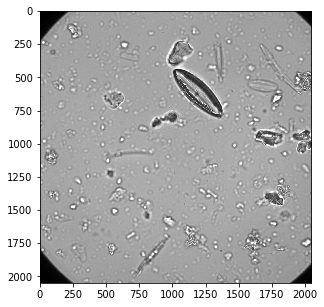

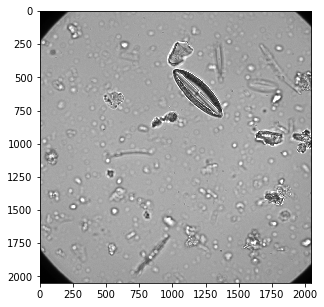

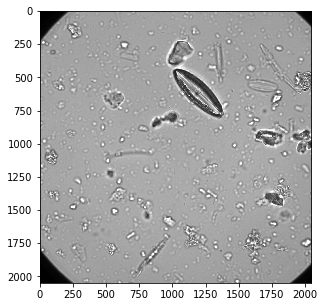

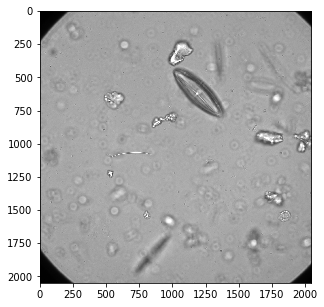

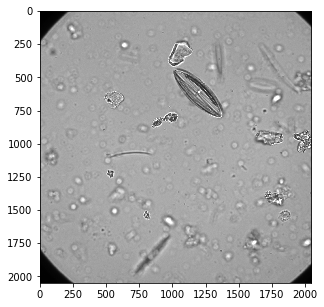

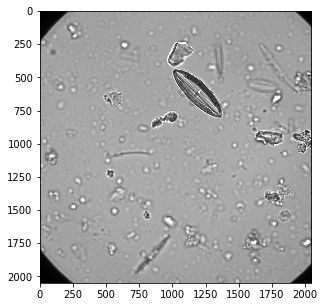

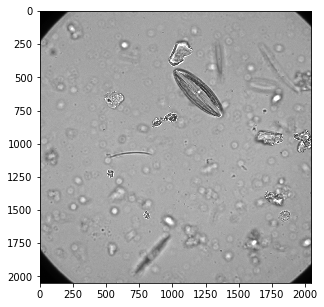

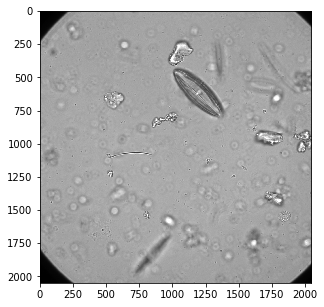

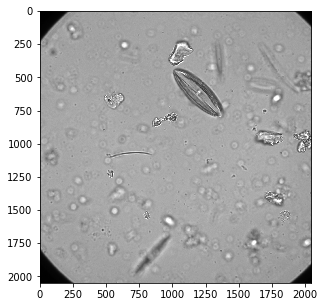

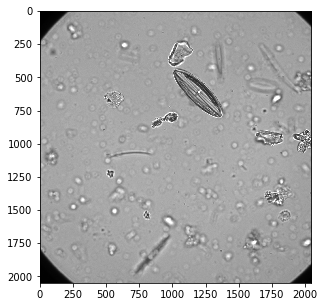

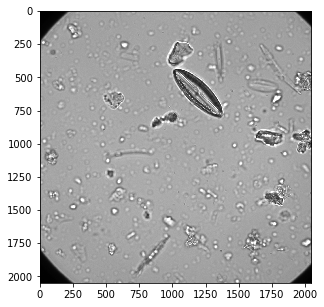

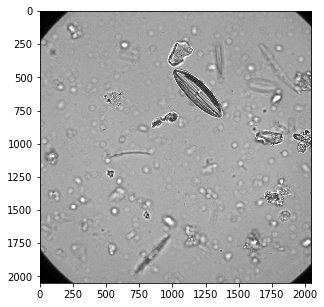

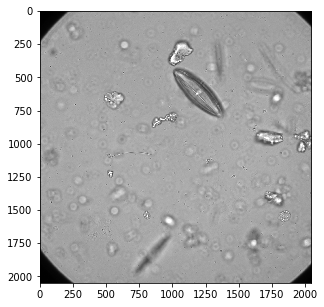

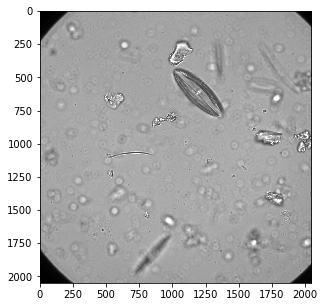

In [2]:
files = glob.glob(os.path.join("B87/B87-1/*.tiff"))
#file_diatoms = []
for file in files:
    I = plt.imread(file)
    plt.figure(figsize=(5,5))
    plt.imshow(I,cmap='gray')
#ne marche pas pour récuperer les images dans un tableau: à revoir
    #file_diatoms = file_diatoms.append(np.array(Image.open(file)))
    
#pour voir les aretes du fichier B87 entier    
    #edges = filters.sobel(I)
    #plt.imshow(edges)

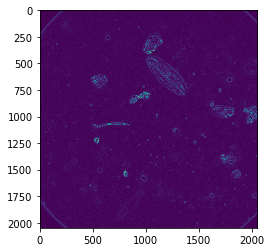

In [3]:
edges = filters.sobel(I)
plt.imshow(edges)

In [4]:
I2=I = plt.imread("B87/B87-1/0-001-X29479-Y28497-Z223251.tiff")

/home/founas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


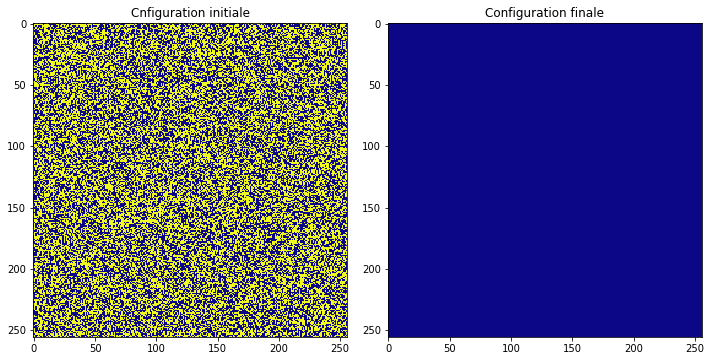

In [4]:
#parametres 
#beta = int(1e-19)
N, Npas = 256, int(1e6)
c=0.3

S0= 2*np.random.randint(2, size = (N,N))-1

def deltaH(i,j,S):
    return -2 * S[i,j] * (S[i-1,j] + S[(i+1)%N,j] + S[i,(j+1)%N] + S[i,(j-1)] + 2*c*(2*I[i,j]-1))

def transition(S,beta):
    (i,j) = np.random.randint(N,size = 2)
    if np.random.rand() < np.exp(beta*deltaH(i,j,S)):
        S[i,j] *= -1
    #if deltaH(i,j,S)>0:
    #    S[i,j] *= -1
    return S

S = np.copy(S0)
for t in range (Npas):
    S = transition(S, 2*np.log(t+2))
    
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
axes[0].imshow(S0, interpolation = 'none', cmap = 'plasma')
axes[0].set_title('Cnfiguration initiale')
axes[1].imshow(S,interpolation = 'none', cmap = 'plasma')
axes[1].set_title('Configuration finale')
fig.tight_layout()
        

In [5]:
def convolution (image,filtre,function):
    new_image = np.zeros(image.shape,np.uint8)
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            new_image[i,j] = function(image,i,j,filtre)
    return new_image

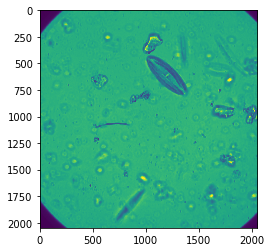

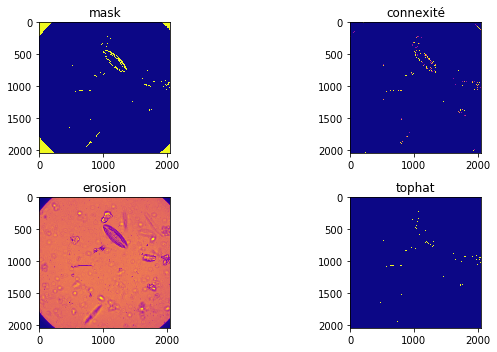

In [50]:


val = filters.threshold_otsu(I)
mask = I < val
mask = mask * 1.
#plt.imshow(mask)

#edges = filters.sobel(mask)
#plt.imshow(edges)

kernel = np.array([[0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0]], dtype= np.uint8)

kernel2 = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
    ], dtype= np.uint8)


erosion = cv2.erode(I, kernel, iterations = 1)
plt.imshow(erosion)

tophat = cv2.morphologyEx(mask, cv2.MORPH_TOPHAT, kernel)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,5))
axes[0,0].imshow(mask, interpolation = 'none', cmap = 'plasma')
axes[0,0].set_title('mask')
axes[0,1].imshow(edges,interpolation = 'none', cmap = 'plasma')
axes[0,1].set_title('connexité')
axes[1,0].imshow(erosion, interpolation = 'none', cmap = 'plasma')
axes[1,0].set_title('erosion')
axes[1,1].imshow(tophat,interpolation = 'none', cmap = 'plasma')
axes[1,1].set_title('tophat')
fig.tight_layout()


In [46]:
mask.dtype


dtype('int64')

TypeError: Only bool or integer image types are supported. Got float64.

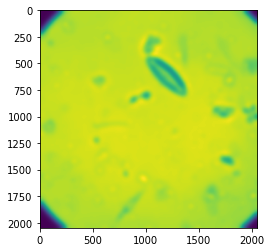

In [42]:

simple_threshold = I > filters.threshold_otsu(I)
adaptive_threshold = filters.threshold_local(I, 151)
plt.imshow(adaptive_threshold)


filters_res = morphology.remove_small_objects(adaptive_threshold,3)                                            
clear_image = segmentation.clear_border(filters_res)

In [ ]:
mask = I < 87
I[mask] = 255
inds_x = np.arange(len(I))
inds_y = (4 * inds_x) % len(I)
I[inds_x, inds_y] = 0

l_x, l_y = I.shape[0], I.shape[1]
X, Y = np.ogrid[:l_x, :l_y]
outer_disk_mask = (X - l_x / 2)**2 + (Y - l_y / 2)**2 > (l_x / 2)**2
I[outer_disk_mask] = 0

plt.figure(figsize=(4, 4))
plt.imshow(I, cmap='gray')
plt.axis('off')
plt.show()

In [20]:
from PIL import Image
im = Image.open("B87/B87-1/0-010-X29479-Y28497-Z223341.tiff")
plt.figure(figsize=(4, 4))
im.rotate(45).show()

<Figure size 288x288 with 0 Axes>

In [23]:
size = 128, 128

for infile in glob.glob("*.tiff"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile)
    im.thumbnail(size)
    im.save(file + ".thumbnail", "JPEG")


In [32]:
Image.alpha_composite(np.array(im), I)

AttributeError: 'numpy.ndarray' object has no attribute 'load'

/home/founas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
/home/founas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.roll is deprecated and will be removed in SciPy 2.0.0, use numpy.roll instead
/home/founas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/home/founas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
/home/founas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/home/founas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: T

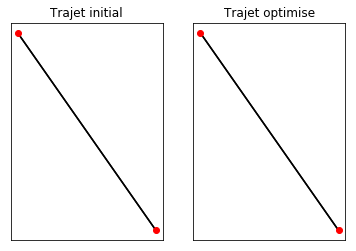

Text(0,0.5,'Temperature')

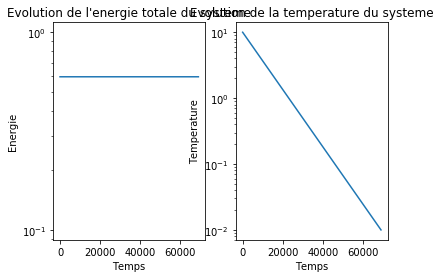

In [2]:
# -*- coding: Latin-1 -*-
# programme de résolution du problème du voyaguer de commerce
# par l'algorithme du recuit simulé
# Dominique Lefebvre pour TangenteX.com
# 14 mars 2017

# importation des librairies
from scipy import *
from matplotlib.pyplot import *

# paramètres du problème
N = 2    # nombre de villes

# paramètres de l'algorithme de recuit simulé
T0 = 10.0
Tmin = 1e-2
tau = 1e4

# fonction de calcul de l'énergie du système, égale à la distance totale
# du trajet selon le chemin courant
def EnergieTotale():
    global trajet
    energie = 0.0
    coord = c_[x[trajet],y[trajet]]
    energie = sum(sqrt(sum((coord - roll(coord,-1,axis=0))**2,axis=1)))
    return energie

# fonction de fluctuation autour de l'état "thermique" du système
def Fluctuation(i,j):
    global trajet
    Min = min(i,j)
    Max = max(i,j)
    trajet[Min:Max] = trajet[Min:Max].copy()[::-1]
    return

# fonction d'implémentation de l'algorithme de Metropolis
def Metropolis(E1,E2):
    global T
    if E1 <= E2:
        E2 = E1  # énergie du nouvel état = énergie système
    else:
        dE = E1-E2
        if random.uniform() > exp(-dE/T): # la fluctuation est retenue avec  
            Fluctuation(i,j)              # la proba p. sinon retour trajet antérieur
        else:
            E2 = E1 # la fluctuation est retenue 
    return E2
    
# initialisation des listes d'historique
Henergie = []     # énergie
Htemps = []       # temps
HT = []           # température

# répartition aléatoire des N villes sur le plan [0..1,0..1]
x = random.uniform(size=N)
y = random.uniform(size=N)

# défintion du trajet initial : ordre croissant des villes
trajet = arange(N)
trajet_init = trajet.copy()

# calcul de l'énergie initiale du système (la distance initiale à minimiser)
Ec = EnergieTotale()

# boucle principale de l'algorithme de recuit simulé
t = 0
T = T0
while T > Tmin:
    # choix de deux villes différentes au hasard
    i = random.random_integers(0,N-1)
    j = random.random_integers(0,N-1)
    if i == j: continue
        
    # création de la fluctuation et mesure de l'énergie
    Fluctuation(i,j) 
    Ef = EnergieTotale()   
    Ec = Metropolis(Ef,Ec)
    
    # application de la loi de refroidissement    
    t += 1
    T = T0*exp(-t/tau)  

    # historisation des données
    if t % 10 == 0:
        Henergie.append(Ec)
        Htemps.append(t)
        HT.append(T)

# fin de boucle - affichage des états finaux
# affichage du réseau
fig1 = figure(1)
subplot(1,2,1)
xticks([])
yticks([])
plot(x[trajet_init],y[trajet_init],'k')
plot([x[trajet_init[-1]], x[trajet_init[0]]],[y[trajet_init[-1]], \
      y[trajet_init[0]]],'k')
plot(x,y,'ro')
title('Trajet initial')

subplot(1,2,2)
xticks([])
yticks([])
plot(x[trajet],y[trajet],'k')
plot([x[trajet[-1]], x[trajet[0]]],[y[trajet[-1]], y[trajet[0]]],'k')
plot(x,y,'ro')
title('Trajet optimise')
show()

# affichage des courbes d'évolution
fig2 = figure(2)
subplot(1,2,1)
semilogy(Htemps, Henergie)
title("Evolution de l'energie totale du systeme")
xlabel('Temps')
ylabel('Energie')
subplot(1,2,2)
semilogy(Htemps, HT)
title('Evolution de la temperature du systeme')
xlabel('Temps')
ylabel('Temperature')
    